# 05_modeling — Baseline & Probabilistic Models
Forecast daily **load (MW)** using hydrology + text features, aligned with proposal.

**Models**
- Baseline: **Persistence** (yesterday = today)
- **Linear Regression** (tabular baseline)
- **Gaussian Process Regression** (probabilistic; mean + uncertainty)

**Data expected**: `master_with_topics.csv` from previous steps.


### Cell 1 — Imports & configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

plt.rcParams['figure.figsize'] = (10,4)

DATA_PATH = "master_with_topics.csv"
DATE_COL  = "date"

# Time-based split (adjust if needed)
TRAIN_END = pd.Timestamp("2021-12-31")
VAL_END   = pd.Timestamp("2022-12-31")  # test will be 2023

print("Expecting:", Path(DATA_PATH).resolve())

Expecting: C:\Users\abhis\Desktop\Big Data\Hydropower decision support system\master_with_topics.csv


### Cell 2 — Load data & detect target/feature columns

In [2]:
df = pd.read_csv(DATA_PATH, parse_dates=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)

# Detect target column
def first_existing(cols):
    for c in cols:
        if c in df.columns:
            return c
    return None

TARGET = first_existing(["load_MW","peak_load_mw","avg_load_mw"])
if TARGET is None:
    raise ValueError("No load column found. Expected one of: load_MW, peak_load_mw, avg_load_mw")

# Candidate features: everything numeric except target
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in num_cols if c != TARGET]

print("Rows:", len(df), "| Target:", TARGET)
print("Feature count:", len(feature_cols))

Rows: 1796 | Target: load_MW
Feature count: 79


### Cell 3 — Clean NaNs & time-based train/val/test split

In [3]:
# Light imputation: forward-fill then back-fill for features only (not target)
X_full = df[[DATE_COL] + feature_cols].copy().set_index(DATE_COL).sort_index()
X_full = X_full.ffill().bfill()

y_full = df[[DATE_COL, TARGET]].copy().set_index(DATE_COL).sort_index()
# Keep target NaNs if any — we'll drop rows where y is NaN
data = X_full.join(y_full, how="inner").dropna(subset=[TARGET]).reset_index()

# Split by dates
train = data[data[DATE_COL] <= TRAIN_END].copy()
val   = data[(data[DATE_COL] > TRAIN_END) & (data[DATE_COL] <= VAL_END)].copy()
test  = data[data[DATE_COL] > VAL_END].copy()

print("Split sizes:", len(train), len(val), len(test))
print("Date ranges:")
print("  Train:", train[DATE_COL].min().date(), "→", train[DATE_COL].max().date())
print("  Val  :", val[DATE_COL].min().date() if len(val) else None, "→", val[DATE_COL].max().date() if len(val) else None)
print("  Test :", test[DATE_COL].min().date(), "→", test[DATE_COL].max().date())

X_tr, y_tr = train[feature_cols], train[TARGET].values
X_va, y_va = val[feature_cols],   val[TARGET].values
X_te, y_te = test[feature_cols],  test[TARGET].values

Split sizes: 1032 354 354
Date ranges:
  Train: 2019-01-31 → 2021-12-20
  Val  : 2022-01-01 → 2022-12-20
  Test : 2023-01-01 → 2023-12-20


### Cell 4 — Metric functions

In [4]:
def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)))

def mae(y_true, y_pred):
    return float(np.mean(np.abs(np.asarray(y_true) - np.asarray(y_pred))))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true != 0
    return float(np.mean(np.abs((y_true[mask]-y_pred[mask]) / y_true[mask]))*100)

def report_metrics(split_name, y_true, y_pred):
    print(f"{split_name} → RMSE={rmse(y_true,y_pred):.2f} | MAE={mae(y_true,y_pred):.2f} | MAPE={mape(y_true,y_pred):.2f}%")

### Cell 5 — Baseline model: Persistence (yesterday = today)

In [5]:
# Build a naive forecast by shifting the target by 1 day within each split
def persistence_predict(df_split):
    s = df_split[[DATE_COL, TARGET]].copy().set_index(DATE_COL).sort_index()
    s['pred'] = s[TARGET].shift(1)
    s = s.dropna()
    return s.index.to_series(), s[TARGET].values, s['pred'].values

# Train
_, y_tr_pers_true, y_tr_pers_pred = persistence_predict(train)
report_metrics("Train (Persistence)", y_tr_pers_true, y_tr_pers_pred)

# Val
if len(val) > 1:
    _, y_va_pers_true, y_va_pers_pred = persistence_predict(val)
    report_metrics("Val   (Persistence)", y_va_pers_true, y_va_pers_pred)

# Test
_, y_te_pers_true, y_te_pers_pred = persistence_predict(test)
report_metrics("Test  (Persistence)", y_te_pers_true, y_te_pers_pred)

Train (Persistence) → RMSE=120.19 | MAE=65.33 | MAPE=4.55%
Val   (Persistence) → RMSE=129.72 | MAE=70.82 | MAPE=4.51%
Test  (Persistence) → RMSE=135.62 | MAE=74.04 | MAPE=4.51%


### Cell 6 — Linear Regression (with StandardScaler)

Train (Linear) → RMSE=7.04 | MAE=2.14 | MAPE=0.15%
Val   (Linear) → RMSE=9.36 | MAE=2.83 | MAPE=0.18%
Test  (Linear) → RMSE=9.65 | MAE=3.07 | MAPE=0.18%


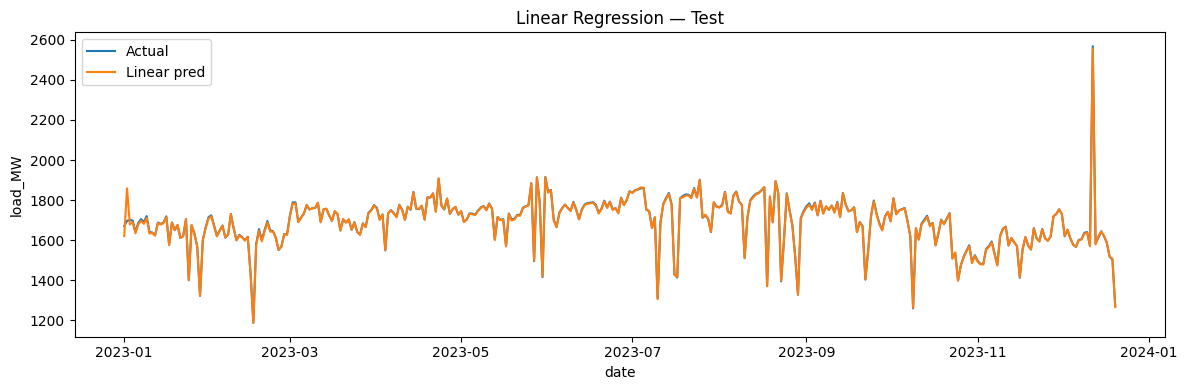

load_MW_rmean3           115.563376
load_MW_diff1             69.653975
load_MW_lag2             -47.950026
load_MW_lag1              21.159355
reservoir_m_lag2          17.426571
reservoir_m_rmean3       -13.303977
reservoir_m                8.291258
outage_flag                7.992176
discharge_m3s_lag1         6.412221
reservoir_m_lag3          -6.171741
reservoir_m_rmean30        5.915146
outage                    -5.814133
reservoir_m_lag1          -5.667303
discharge_m3s_lag2        -5.195908
discharge_m3s_rmean3      -5.100053
load_MW_rmean7             4.493714
flood_flag                 4.180015
discharge_m3s_rmean30     -3.787937
discharge_m3s_lag3         3.273276
maintenance               -3.152018
dtype: float64

In [6]:
lin = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", LinearRegression())
])
lin.fit(X_tr, y_tr)

pred_tr = lin.predict(X_tr)
report_metrics("Train (Linear)", y_tr, pred_tr)

if len(val):
    pred_va = lin.predict(X_va)
    report_metrics("Val   (Linear)", y_va, pred_va)

pred_te = lin.predict(X_te)
report_metrics("Test  (Linear)", y_te, pred_te)

# Quick plot on test
plt.figure(figsize=(12,4))
plt.plot(test[DATE_COL], y_te, label="Actual")
plt.plot(test[DATE_COL], pred_te, label="Linear pred")
plt.title("Linear Regression — Test")
plt.xlabel("date"); plt.ylabel(TARGET)
plt.legend(); plt.tight_layout(); plt.show()

# Coeff summary (top absolute weights)
coefs = pd.Series(lin.named_steps["model"].coef_, index=feature_cols).sort_values(key=np.abs, ascending=False)
coefs.head(20)

### Cell 7 — Gaussian Process Regression (mean + uncertainty)

Train (GP non-load) → RMSE=76.05 | MAE=41.69 | MAPE=2.88%
Val   (GP non-load) → RMSE=105.35 | MAE=72.57 | MAPE=4.50%
Test  (GP non-load) → RMSE=129.28 | MAE=101.16 | MAPE=5.94%
Test PI coverage (~95% target): 91.2%


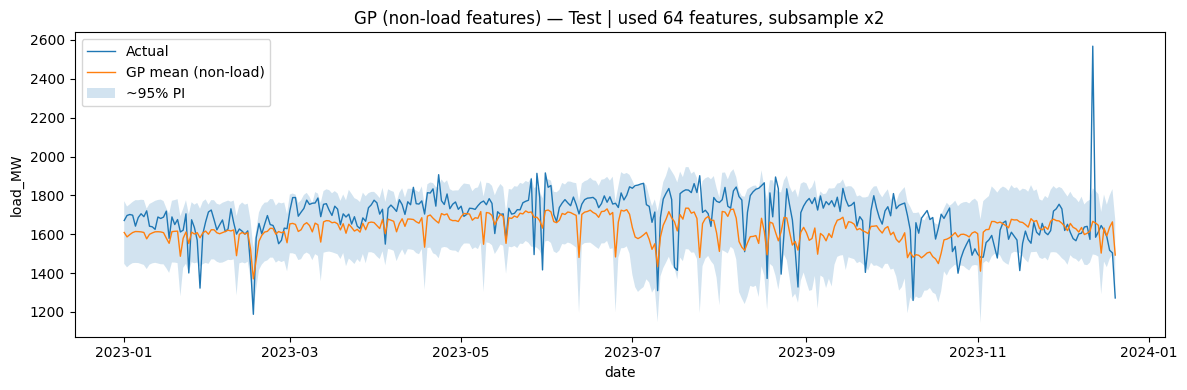

In [10]:
# === Cell 7 (Proposal-aligned, fast & regularized Gaussian Process) ===
# - Uses ONLY hydrology/text features (no load lags) to avoid target leakage
# - Top-K feature selection on TRAIN only
# - Optional train subsampling to speed up O(N^3)
# - Simple scalar RBF + WhiteKernel, no optimizer restarts
# - Reports mean + 95% PI and metrics on Val/Test

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ---- knobs (tune if needed) ----
TOP_K = 70         # reduce feature count (None to keep all)
SUBSAMPLE_EVERY = 2 # 1=no subsample, 2=every 2nd day, 3=every 3rd day
RETURN_STD = True   # keep True for proposal's uncertainty bands
# --------------------------------

# 1) Exclude any load-derived features (names containing "load")
nonload_cols = [c for c in feature_cols if "load" not in c.lower()]
X_tr_nl = X_tr[nonload_cols].copy()
X_va_nl = X_va[nonload_cols].copy() if len(val) else X_va
X_te_nl = X_te[nonload_cols].copy()

# 2) Top-K feature selection on TRAIN ONLY to avoid leakage
use_cols = X_tr_nl.columns.tolist()
if TOP_K is not None and TOP_K < len(use_cols):
    # corr w.r.t. TRAIN target only
    corr = pd.concat([X_tr_nl, pd.Series(y_tr, index=X_tr_nl.index, name="__y__")], axis=1).corr()["__y__"].abs()
    topk = corr.drop("__y__", errors="ignore").sort_values(ascending=False).head(TOP_K).index.tolist()
    use_cols = [c for c in use_cols if c in topk]

X_tr_use = X_tr_nl[use_cols]
X_va_use = X_va_nl[use_cols] if len(val) else X_va_nl
X_te_use = X_te_nl[use_cols]

# 3) Optional subsampling of TRAIN to speed up GP (O(N^3))
if SUBSAMPLE_EVERY > 1:
    tr_idx = X_tr_use.index[::SUBSAMPLE_EVERY]
    X_fit = X_tr_use.loc[tr_idx]
    y_fit = y_tr[::SUBSAMPLE_EVERY]
else:
    X_fit = X_tr_use
    y_fit = y_tr

# 4) Regularized kernel (scalar RBF + white noise), no restarts for speed
kernel = C(1.0) * RBF(length_scale=5.0, length_scale_bounds=(1e-1, 1e3)) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-3, 10.0))
gpr_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", GaussianProcessRegressor(
        kernel=kernel,
        normalize_y=True,
        n_restarts_optimizer=0,
        optimizer="fmin_l_bfgs_b",
        random_state=42,
    ))
])

# Fit
gpr_reg.fit(X_fit, y_fit)

def gpr_predict(pipe, X, return_std=True):
    Z = pipe.named_steps["scaler"].transform(X)
    return pipe.named_steps["model"].predict(Z, return_std=return_std)

# Train metrics
m_tr, s_tr = gpr_predict(gpr_reg, X_tr_use, RETURN_STD)
report_metrics("Train (GP non-load)", y_tr, m_tr)

# Val metrics
if len(val):
    m_va, s_va = gpr_predict(gpr_reg, X_va_use, RETURN_STD)
    report_metrics("Val   (GP non-load)", y_va, m_va)

# Test metrics + plot with uncertainty
m_te, s_te = gpr_predict(gpr_reg, X_te_use, RETURN_STD)
report_metrics("Test  (GP non-load)", y_te, m_te)

plt.figure(figsize=(12,4))
plt.plot(test[DATE_COL], y_te, label="Actual", linewidth=1)
plt.plot(test[DATE_COL], m_te, label="GP mean (non-load)", linewidth=1)
if RETURN_STD:
    upper = m_te + 1.96*s_te
    lower = m_te - 1.96*s_te
    plt.fill_between(test[DATE_COL], lower, upper, alpha=0.2, label="~95% PI")
    coverage = ((y_te >= lower) & (y_te <= upper)).mean()
    print(f"Test PI coverage (~95% target): {coverage*100:.1f}%")
plt.title(f"GP (non-load features) — Test | used {len(use_cols)} features, subsample x{SUBSAMPLE_EVERY}")
plt.xlabel("date"); plt.ylabel(TARGET)
plt.legend(); plt.tight_layout(); plt.show()


### Cell 8 — Save predictions for reporting

In [11]:
out_te = pd.DataFrame({
    "date": test[DATE_COL].values,
    "y_true": y_te,
    "lin_pred": pred_te,
    "gpr_mean": m_te,
    "gpr_std": s_te,
    "gpr_pi_low": m_te - 1.96*s_te,
    "gpr_pi_high": m_te + 1.96*s_te,
})
out_te.to_csv("predictions_test.csv", index=False)
print("Saved predictions_test.csv | rows:", len(out_te))
out_te.head()

Saved predictions_test.csv | rows: 354


,date,y_true,lin_pred,gpr_mean,gpr_std,gpr_pi_low,gpr_pi_high
0,2023-01-01,1670.766,1620.964611,1609.053075,82.375972,1447.596170,1770.509980
1,2023-01-02,1696.572,1859.125929,1586.288225,79.840831,1429.800196,1742.776255
2,2023-01-03,1701.678,1678.898659,1598.368281,79.375243,1442.792805,1753.943756
3,2023-01-04,1698.090,1690.563242,1608.820072,80.341291,1451.351142,1766.289002
4,2023-01-05,1641.786,1634.764534,1614.023766,82.405297,1452.509384,1775.538147
